In [57]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np
import os
import itertools
import math

# Read Confusion

In [58]:
!pwd

/home/dmlab/RolesWithinHyperedge_minibatch/analyze


In [59]:
test_epoch = 10
dataname = "emailEnron_10000"

In [60]:
def read_confusion_matrices(dirpath, fname="log_test_confusion.txt", ep=100):
    if os.path.isfile(dirpath + fname) is False:
        return -1
    if os.path.isfile(dirpath + "log_train.txt"):
        with open(dirpath + "log_train.txt", "r") as f:
            for line in f.readlines():
                ep_str = line.rstrip().split(": ")[0]
                ep_str, _ = ep_str.split(" ")
        num_epoch = int(ep_str)
    else:
        num_epoch = ep
    if num_epoch < 70:
        return -1
    if os.path.isfile(dirpath + "log_test_macro.txt"):
        with open(dirpath + "log_test_macro.txt", "r") as f:
            lastline = f.readlines()[-1]
            lastline = lastline.split("/")[1:]
            acc_macro = float(lastline[0].split(":")[-1])
            prec_macro = float(lastline[1].split(":")[-1])
            rec_macro = float(lastline[2].split(":")[-1])
            f1_macro = float(lastline[3].split(":")[-1])
    else:
        f1_macro = -1
    if os.path.isfile(dirpath + "log_test_micro.txt"):
        with open(dirpath + "log_test_micro.txt", "r") as f:
            lastline = f.readlines()[-1]
            lastline = lastline.split("/")[1:]
            acc_micro = float(lastline[0].split(":")[-1])
            prec_micro = float(lastline[1].split(":")[-1])
            rec_micro = float(lastline[2].split(":")[-1])
            f1_micro = float(lastline[3].split(":")[-1])
    else:
        f1_micro = -1

    with open(dirpath + fname, "r") as f:
        three_line = []
        for line in f.readlines():
            if len(three_line) == 3:
                num_epoch += test_epoch
                three_line = []
            three_line.append(line)
    confusion_matrix = np.zeros((3,3))
    for i in range(3):
        line = three_line[i].rstrip()
        c1, c2, c3 = line.split("\t")
        c1, c2, c3 = int(c1), int(c2), int(c3)
        confusion_matrix[i,0] = c1
        confusion_matrix[i,1] = c2
        confusion_matrix[i,2] = c3
    
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1] + confusion_matrix[2,2]) / (np.sum(confusion_matrix))
    
    rec_bar = []
    label_num = []
    recall_micro_denom = 0
    recall_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        row_sum = np.sum(confusion_matrix[i])
        label_num.append(row_sum)
        ans = confusion_matrix[i,i]
        if row_sum == 0:
            rec_bar.append(0)
        else:
            rec_bar.append(ans / row_sum)
        recall_micro_denom += row_sum
        recall_micro_numer += ans
    
    recall_macro = sum(rec_bar) / 3
    recall_micro = recall_micro_numer / recall_micro_denom
    
    prec_bar = []
    pred_label_num = []
    precision_micro_denom = 0
    precision_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        col_sum = np.sum(confusion_matrix[:,i])
        pred_label_num.append(col_sum)
        ans = confusion_matrix[i,i]
        if col_sum == 0:
            prec_bar.append(0)
        else:
            prec_bar.append(ans / col_sum)
        precision_micro_denom += col_sum
        precision_micro_numer += ans
    precision_macro = sum(prec_bar) / 3
    precision_micro = precision_micro_numer / precision_micro_denom
    
    f1_bar = []
    for i in range(len(rec_bar)):
        if (prec_bar[i] + rec_bar[i]) == 0:
            f1_bar.append(0)
        else:
            f1_bar.append(2 * ( (prec_bar[i] * rec_bar[i]) / (prec_bar[i] + rec_bar[i]) ))
    f1score_macro = sum(f1_bar) / 3
    f1score_micro = 2 * ( (precision_micro * recall_micro) / (precision_micro + recall_micro))
    
    numlabelrate = []
    for i in range(3):
        numlabelrate.append(pred_label_num[i] / label_num[i])
    
    result = {
        "accuracy" : accuracy,
        "f1_micro": f1score_micro,
        "f1_macro": f1score_macro,
        "num_epoch" : num_epoch
    }
    for i in range(3):
        result["recall_" + str(i)] = rec_bar[i]
        result["precision_" + str(i)] = prec_bar[i]
        result["f1_" + str(i)] = f1_bar[i]
        result["labelratio_" + str(i)] = numlabelrate[i]
    
    if f1_macro != -1:
        if abs(recall_macro - rec_macro) >= 1e-2:
            print(confusion_matrix)
        assert abs(recall_macro - rec_macro) < 1e-2, str(recall_macro) + " -- " + str(rec_macro) + " -- " + dirpath
        assert abs(recall_micro - rec_micro) < 1e-2, str(recall_micro) + " -- " + str(rec_micro) + " -- " + dirpath
        assert abs(precision_macro - prec_macro) < 1e-2, str(precision_macro) + " -- " + str(prec_macro) + " -- " + dirpath
        assert abs(precision_micro - prec_micro) < 1e-2, str(precision_micro) + " -- " + str(prec_micro) + " -- " + dirpath
        assert abs(f1score_macro - f1_macro) < 1e-2, str(f1score_macro) + " -- " + str(f1_macro) + " -- " + dirpath
        assert abs(f1score_micro - f1_micro) < 1e-2, str(f1score_micro) + " -- " + str(f1_micro) + " -- " + dirpath
    return result

# Make Dict

In [61]:
resultdict = defaultdict(dict)
ep=200

baselinename_list = ["baseline1", "baseline0"]
nongraph_list = ["RandomForest", "MLP", "LogisticRegressor"]

In [62]:
for baselinename in baselinename_list:
    res = read_confusion_matrices("../nongraph_results/" + dataname + "/", fname= baselinename + "_confusion.txt", ep=ep)
    assert res != -1, baselinename
    res["searchspace"] = 1
    resultdict[baselinename] = res

In [63]:
for nongraphmodel in nongraph_list:
    res = read_confusion_matrices("../nongraph_results/" + dataname + "/" + nongraphmodel + "/", fname= "All_confusion.txt", ep=ep)
    assert res != -1, nongraphmodel
    res["searchspace"] = 1
    resultdict[nongraphmodel] = res

In [64]:
# Add F1 macro
for initvec in ["onehot", "adj", "rw"]:
    orgdir = "../results/" + dataname + "/" + initvec + "/"
    for modelname in os.listdir(orgdir):
        modelnamedir = orgdir + modelname + "/"
        if os.path.isdir(modelnamedir) is False:
            continue
        param2f1macro = {}
        for paramname in os.listdir(modelnamedir):
            paramnamedir = modelnamedir + paramname + "/"
            if os.path.isfile(paramnamedir + "log_test_confusion.txt"):
                res = read_confusion_matrices(paramnamedir, ep=ep)
                if res != -1:
                    param2f1macro[paramname] = res["f1_macro"]
        
        if len(param2f1macro) == 0:
            continue
        sorted_param = sorted(list(param2f1macro.keys()), key=lambda x: param2f1macro[x], reverse=True)
        paramdir = sorted_param[0]
        if "RankQ-PrevQ" in modelname:
            print(paramdir)
        res = read_confusion_matrices(modelnamedir + paramdir + "/", ep=ep)
        if res == -1:
            print(modelname)
        else:
            res["searchspace"] = len(param2f1macro)
            resultdict[modelname + "/" + initvec] = res

lr_0.001_gm_0.99_bs_64_nh_4_do_0.5_nsp_-1
lr_0.001_gm_0.99_bs_64_nh_4_do_0.5_nsp_-1


In [65]:
samplingsize_analyze = {}

In [82]:
for initvec in ["onehot", "adj", "rw"]:
    orgdir = "../results/" + dataname + "/" + initvec + "/"
    for modelname in os.listdir(orgdir):
        modelnamedir = orgdir + modelname + "/"
        if "transformer" not in modelname:
            continue
        elif os.path.isdir(modelnamedir) is False:
            continue
        samplingsize2result = {}
        samplingsize2result_2 = {}
        for paramname in os.listdir(modelnamedir):
            paramnamedir = modelnamedir + paramname + "/"
            tmp = paramname.split("_")
            if tmp[-1] == "csp":
                if tmp[-3] != "sp":
                    continue
                samplingsize = int(tmp[-2])
                if samplingsize == 10 and "AvgAgg" in modelname:
                    continue
                if os.path.isfile(paramnamedir + "log_test_confusion.txt"):
                    res = read_confusion_matrices(paramnamedir, ep=ep)
                    if res != -1:
                        samplingsize2result_2[samplingsize] = res
            else:
                if tmp[-2] != "sp" and tmp[-2] != "nsp":
                    continue
                samplingsize = int(tmp[-1])
                if os.path.isfile(paramnamedir + "log_test_confusion.txt"):
                    res = read_confusion_matrices(paramnamedir, ep=ep)
                    if res != -1:
                        if samplingsize not in samplingsize2result:
                            samplingsize2result[samplingsize] = res
                        elif samplingsize2result[samplingsize]["f1_macro"] < res["f1_macro"]:
                            samplingsize2result[samplingsize] = res
                            print(modelname, paramnamedir)
                
        if len(samplingsize2result) == 0:
            continue
        if "_half" in modelname:
            tmp_modelname = "_".join(modelname.split("_")[:2])
        else:
            tmp_modelname = modelname.split("_")[0]
        _, encodetype, decodetype = tmp_modelname.split("-")
        if len(samplingsize2result_2) != 0:
            samplingsize_analyze[encodetype + "_" + decodetype + "_csp"] = samplingsize2result_2
        samplingsize_analyze[encodetype + "_" + decodetype] = samplingsize2result

transformer-RankQ-AvgAgg_nl2_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-AvgAgg_nl2_sm_snl1/lr_0.001_gm_0.99_bs_128_nh_4_do_0.6_sp_45/
transformer-RankQ-AvgAgg_nl2_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-AvgAgg_nl2_sm_snl1/lr_0.001_gm_0.999_bs_128_nh_4_do_0.6_sp_45/
transformer-RankQ-AvgAgg_nl2_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-AvgAgg_nl2_sm_snl1/lr_0.001_gm_0.999_bs_64_nh_4_do_0.6_sp_45/
transformer-RankQ-PrevQ_nl2_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-PrevQ_nl2_sm_snl1/lr_0.001_gm_0.999_bs_64_nh_4_do_0.6_sp_15/
transformer-RankQ-PrevQ_nl2_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-PrevQ_nl2_sm_snl1/lr_0.001_gm_0.99_bs_64_nh_4_do_0.6_sp_15/
transformer-RankQ-PrevQ_nl1_sm_snl1 ../results/emailEnron_10000/rw/transformer-RankQ-PrevQ_nl1_sm_snl1/lr_0.001_gm_0.99_bs_64_nh_4_do_0.5_nsp_-1/
transformer-pure-pure_nl1_sm_snl1 ../results/emailEnron_10000/rw/transformer-pure-pure_nl1_sm_snl1/lr_0.001_gm_0.99_bs

In [83]:
colordict = {
    "pure_pure": "gray",
    
    "RankQ_AvgAgg": "#EB0000",
    "RankQ_half_AvgAgg": "#F06464",
    
    "RankQ_PrevQ": "#80E12A",
    "RankQ_half_PrevQ": "#228B22",
    
    "RankQ_PrevQ_csp": "#6A5ACD"
}

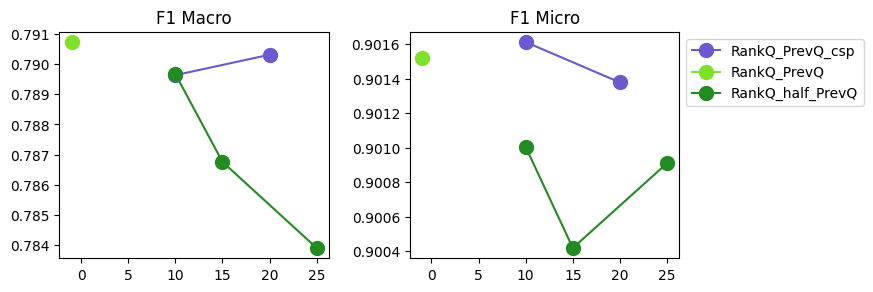

In [84]:
fig, axes = plt.subplots(dpi=100, nrows=1, ncols=2, figsize=(8,3))
for modelname in samplingsize_analyze:
    if "RankQ_PrevQ" in modelname or "RankQ_half_PrevQ" in modelname:
        splist = sorted(samplingsize_analyze[modelname].keys())
        f1macro = [samplingsize_analyze[modelname][sp]["f1_macro"] for sp in splist]
        f1micro = [samplingsize_analyze[modelname][sp]["f1_micro"] for sp in splist]

        axes[0].plot(splist, f1macro, label=modelname, marker="o", markersize=10, color=colordict[modelname])
        axes[1].plot(splist, f1micro, label=modelname, marker="o", markersize=10, color=colordict[modelname])
    
axes[1].legend(bbox_to_anchor=(1,1))
axes[0].set_title("F1 Macro")
axes[1].set_title("F1 Micro")
fig.subplots_adjust(wspace=0.3)
plt.show()
plt.close()

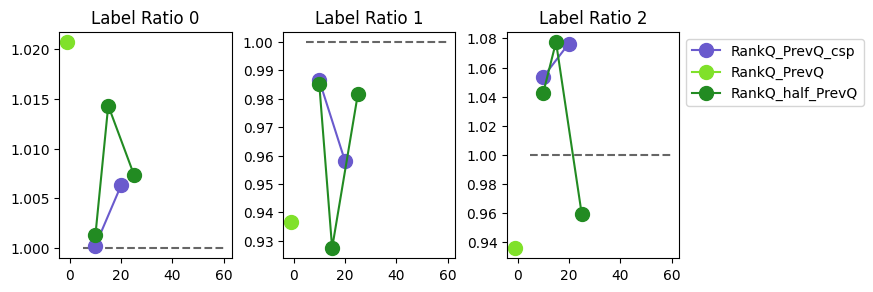

In [69]:
fig, axes = plt.subplots(dpi=100, nrows=1, ncols=3, figsize=(8,3))
for modelname in samplingsize_analyze:
    if "RankQ_PrevQ" in modelname or "RankQ_half_PrevQ" in modelname:
        splist = sorted(samplingsize_analyze[modelname].keys())
        for i in range(3):
            labelratio = [samplingsize_analyze[modelname][sp]["labelratio_" + str(i)] for sp in splist]

            axes[i].plot(splist, labelratio, label=modelname, marker="o", markersize=10, color=colordict[modelname])
    
axes[2].legend(bbox_to_anchor=(1,1))
for i in range(3):
    axes[i].set_title("Label Ratio " + str(i))
    axes[i].hlines(1, 5, 60, linestyle="dashed", alpha=0.6, color="black")
fig.subplots_adjust(wspace=0.3)
plt.show()
plt.close()

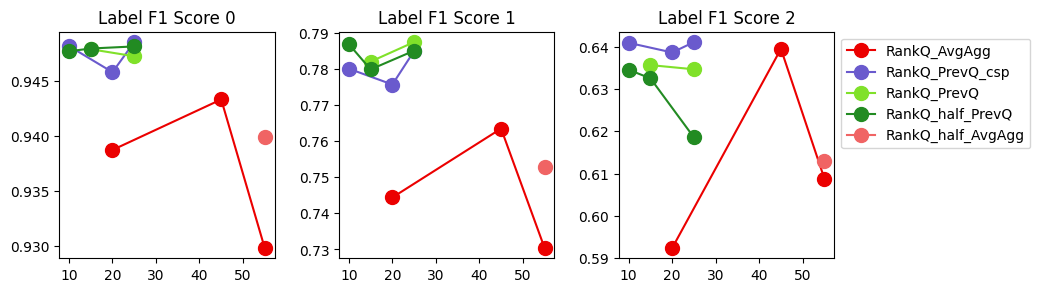

In [34]:
fig, axes = plt.subplots(dpi=100, nrows=1, ncols=3, figsize=(10,3))
for modelname in samplingsize_analyze:
    splist = sorted(samplingsize_analyze[modelname].keys())
    for i in range(3):
        labelratio = [samplingsize_analyze[modelname][sp]["f1_" + str(i)] for sp in splist]
        
        axes[i].plot(splist, labelratio, label=modelname, marker="o", markersize=10, color=colordict[modelname])
    
axes[2].legend(bbox_to_anchor=(1,1))
for i in range(3):
    axes[i].set_title("Label F1 Score " + str(i))
#     axes[i].hlines(1, 5, 60, linestyle="dashed", alpha=0.6, color="black")
fig.subplots_adjust(wspace=0.3)
plt.show()
plt.close()

In [40]:
evallist = ["f1_micro", "f1_macro"] + list(itertools.chain.from_iterable([["recall_" + str(i),  "precision_" + str(i), "f1_" + str(i), 'labelratio_' + str(i)] for i in range(3)]))
print(evallist)
print(len(evallist))

['f1_micro', 'f1_macro', 'recall_0', 'precision_0', 'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1', 'labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2']
14


In [41]:
outputname = "search0326_{}.txt".format(dataname)
with open(outputname, "w") as f:
    line = "Model,InitVec,Encode,Decode,Partial," + ",".join(evallist) + ",searchspace"
    f.write(line + "\n")

In [42]:
for k in resultdict:
    if k in baselinename_list:
        model = k
        initvec, encode, decode, partialflag, scorer = "-", "-", "-", "-", "-"
        nl, snl = 0, 0        
    elif k in nongraph_list:
        model = k
        initvec, encode, decode, partialflag, scorer = "-", "-", "-", "-", "-"
        nl, snl = 0, 0
    else:
        tmp = k.split("/")
        assert len(tmp) == 2
        initvec = tmp[-1]
        _k = tmp[0]
        if "partial" in _k:
            partialflag = "partial"
            modelname, nl, _, scorer, snl = _k.split("_")
        elif "_half" in _k:
            partialflag = "-"
            modelname1, modelname2, nl, scorer, snl = _k.split("_")
            modelname = "_".join([modelname1, modelname2])
        else:
            partialflag = "-"
            modelname, nl, scorer, snl = _k.split("_")
        if "transformer" in modelname:
            model, encode, decode = modelname.split("-")
        else:
            tmp = modelname.split("-")
            if len(tmp) == 1:
                model = tmp[0]
                encode = "-"
            elif len(tmp) == 2:
                model = tmp[0]
                encode = tmp[1]
            decode = "-"

        nl = int(nl[2:])
        snl = int(snl[3:])
        
    line = [model, initvec, encode, decode, partialflag] + [str(resultdict[k][e]) for e in evallist] + [str(resultdict[k]["searchspace"])]
    line = ",".join(line)
    with open(outputname, "a") as f:
        f.write(line + "\n")

In [43]:
d.columns

Index(['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'f1_micro',
       'f1_macro', 'recall_0', 'precision_0', 'f1_0', 'labelratio_0',
       'recall_1', 'precision_1', 'f1_1', 'labelratio_1', 'recall_2',
       'precision_2', 'f1_2', 'labelratio_2', 'searchspace'],
      dtype='object')

In [44]:
d = pd.read_csv(outputname)
d = d[d["Decode"] != "AvgAggRes"]
d = d[d["Decode"] != "PureRes"]
d = d.sort_values(by=["f1_macro"], ascending=False)
d[['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'f1_micro', 'f1_macro', 'f1_0', 'labelratio_0', 'f1_1', 'labelratio_1', 'f1_2', 'labelratio_2']]

,Model,InitVec,Encode,Decode,Partial,f1_micro,f1_macro,f1_0,labelratio_0,f1_1,labelratio_1,f1_2,labelratio_2
2,RandomForest,-,-,-,-,0.926283,0.837886,0.960947,1.008109,0.861136,0.986443,0.691574,0.94050
10,transformer,rw,RankQ,PrevQ,-,0.901892,0.791313,0.948960,1.002231,0.787088,0.957867,0.637891,1.14300
13,transformer,rw,RankQ,PrevQ,-,0.901517,0.790739,0.948371,0.997397,0.787437,1.000942,0.636408,1.03800
16,transformer,rw,RankQ_half,PrevQ,-,0.901003,0.789682,0.947667,1.001301,0.786862,0.985054,0.634517,1.04250
9,transformer,rw,RankQ,AvgAgg,-,0.893755,0.782081,0.943295,1.009854,0.763482,0.940097,0.639466,1.09550
23,transformer,rw,pure,pure,-,0.890435,0.772663,0.941569,0.997676,0.765245,0.976227,0.611176,1.13850
22,transformer,rw,RankQ_half,AvgAgg,-,0.888447,0.768566,0.939901,1.020606,0.752787,0.889490,0.613009,1.13700
21,hat,rw,sum,-,-,0.873927,0.738542,0.932030,1.003625,0.725587,0.993409,0.558010,0.96950
12,hat,rw,-,-,-,0.869882,0.735598,0.929828,1.013169,0.708397,0.938449,0.568570,1.04900
19,hnhn,rw,-,-,-,0.857677,0.725185,0.920882,1.013479,0.676851,0.956808,0.577823,0.96600


In [43]:
# a = d[d["Encode"] == "sum"]
a = d.groupby(by=['Encode']).mean()
a

,f1_micro,f1_macro,recall_0,precision_0,f1_0,labelratio_0,recall_1,precision_1,f1_1,labelratio_1,recall_2,precision_2,f1_2,labelratio_2,searchspace
Encode,,,,,,,,,,,,,,,
-,0.734055,0.570706,0.793531,0.793643,0.785455,0.903383,0.599468,0.573643,0.551300,1.275728,0.371023,0.411975,0.375363,1.203523,2.454545
RankQ,0.872041,0.719714,0.937376,0.925060,0.931152,1.013603,0.708838,0.732738,0.720407,0.971166,0.511167,0.529629,0.507584,0.903000,8.000000
RankQ_half,0.894725,0.779124,0.948934,0.938732,0.943784,1.010954,0.746087,0.796191,0.769825,0.937272,0.651500,0.598830,0.623763,1.089750,2.000000
pure,0.827094,0.617066,0.916522,0.895543,0.905911,1.023426,0.619630,0.621606,0.620616,0.996822,0.265500,0.417781,0.324671,0.635500,1.000000
sum,0.841677,0.636635,0.924888,0.903115,0.913824,1.024417,0.644541,0.648567,0.645359,0.998745,0.336500,0.532975,0.350722,0.611333,2.333333


## Initial Vec

* initial vector 방법마다 6가지를 bar로 표현
* table을 initial vector로 groupby
* transformer-RankQ-AvgAgg/* 만 바꾸면서 여러 evaluation

## Encode

* initial vector 방법마다 6가지를 bar로 표현
* table을 initial vector로 groupby
* transformer-RankQ-AvgAgg/* 만 바꾸면서 여러 evaluation
* ranking을 쓰는 것이 좋은가라는 질문 답하기: transformer, gat, hnhn 각각 대표 하나로...!

## Partial

* 가장 좋은 성능 보이는 모델과 partial을 비교

## Total Comparison

* HNHN / GAT / Transformer - X / Rank + baseline 살펴보기

In [31]:
encodercolor = {
    "PosEnc" : "#e41a1c",
    "RankQ" : "#377eb8",
    "adj" : "#4daf4a",
    "pure" : "#984ea3",
    "sum" : "#ff7f00",
    "rw" : "#ffff33",
}
decodercolor = {
    "AvgAgg" : "#e41a1c",
    "AvgAggRes" : "#377eb8",
    "pure" : "#4daf4a",
    "PrevQ" : "#984ea3",
    "pureRes" : "#ff7f00"
}
initialveccolor = {
    "rw": 'red',
    "adj":  "green",
    "onehot":  "skyblue"
}

In [38]:
# grouplist = defaultdict(dict)
# for iv in ["rw", "adj", "onehot"]:
#     for encode in ["RankQ", "sum", "pure"]:
#         for decode in ["AvgAgg", "pure"]:
#             grouplist[iv][encode + "-" + decode] = "transformer-" + encode + "-" + decode + "_nl2_sm_snl1"+ "/" + iv

grouplist = defaultdict(dict)
for encode in ["RankQ", "sum", "pure"]:
    for iv in ["rw", "adj", "onehot"]:
        for decode in ["AvgAgg", "pure"]:
            grouplist[encode][iv + "/" + decode] = "transformer-" + encode + "-" + decode + "_nl2_sm_snl1"+ "/" + iv

In [39]:
def plot_total_eval(dictlist, colordict, result, w = 1 / 4):
    fig, axes = plt.subplots(dpi=100, figsize=(12,4), nrows=1, ncols=2)
    
    keylist = list(dictlist.keys())
    xs = list(dictlist[keylist[0]].keys())
    
    for eidx, evalname in enumerate(["f1_micro", "f1_macro"]):
        for kidx, key in enumerate(keylist):
            ys = []
            for x in xs:
                modelname = dictlist[key][x]
                ys.append(result[modelname][evalname])
            axes[eidx].bar(np.arange(len(xs)) + (w*(kidx-1)), ys, width=w, align='center', label=key, color=colordict[key])
            
        axes[eidx].set_xticks(np.arange(len(xs)))
        axes[eidx].set_xticklabels(xs, fontsize=13, rotation=90)
        axes[eidx].set_title(evalname)
        axes[eidx].autoscale(tight=True)
        axes[eidx].hlines(result["RandomForest"][evalname], -0.5, len(xs) - 0.5, linestyle="dashed", color="black", label="RandomForest")
        if eidx == 1:
            axes[eidx].legend(bbox_to_anchor=(1,1))

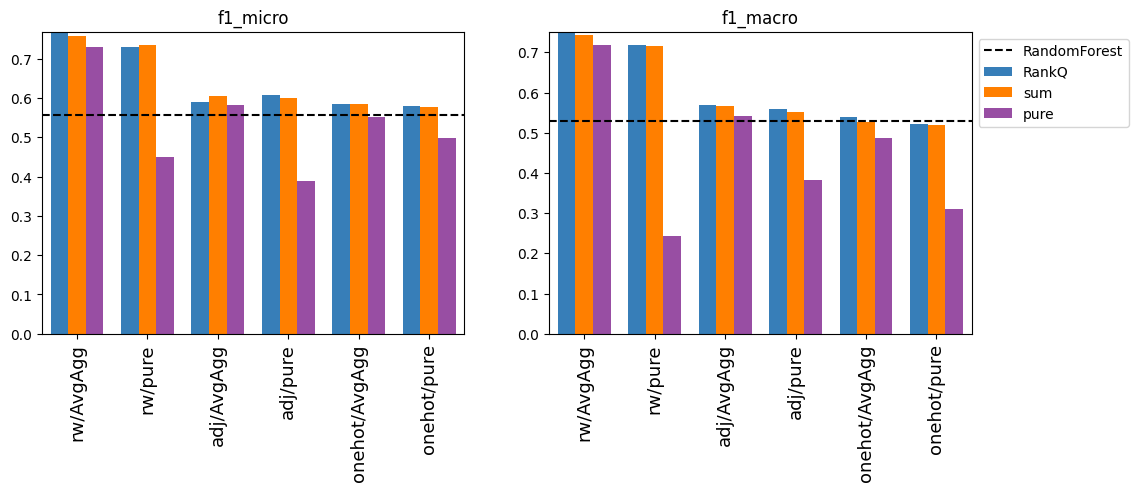

In [40]:
# plot_total_eval(grouplist, initialveccolor, resultdict)
plot_total_eval(grouplist, encodercolor, resultdict)

In [41]:
# label2name = {
#     "rw" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/rw",
#     "adj": "transformer-RankQ-AvgAgg_nl2_sm_snl1/adj",
#     "onehot": "transformer-RankQ-AvgAgg_nl2_sm_snl1/onehot",
# }

label2name = {
    "RankQ" : "transformer-RankQ-AvgAgg_nl2_sm_snl1/rw",
    "sum": "transformer-sum-AvgAgg_nl2_sm_snl1/rw",
    "pure": "transformer-pure-AvgAgg_nl2_sm_snl1/rw",
}

In [42]:
def plot_label_detail(label2name,colordict, result, w=1/4):
    fig, axes = plt.subplots(dpi=100, figsize=(20,4), nrows=1, ncols=3)

    for l in range(3):
        ax = axes[l]
        evallist = ['recall_' + str(l), 'precision_' + str(l), 'f1_' + str(l), 'labelratio_' + str(l)]
        for lidx, label in enumerate(label2name.keys()):
            ys = [result[label2name[label]][e] for e in evallist]
            ax.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label, color=colordict[label])
        
        ys = [result["RandomForest"][e] for e in evallist]
        ax.plot(evallist, ys, linestyle="dashed", color="black", label="RandomForest", linewidth=7)
        
        ax.set_xticks(np.arange(len(evallist)))
        ax.set_xticklabels(evallist, fontsize=13)

        if l == 2:
            ax.legend(bbox_to_anchor=(1,1))
        # ax.xaxis_date()
        ax.set_title("Label : " + str(l))
        ax.autoscale(tight=True)

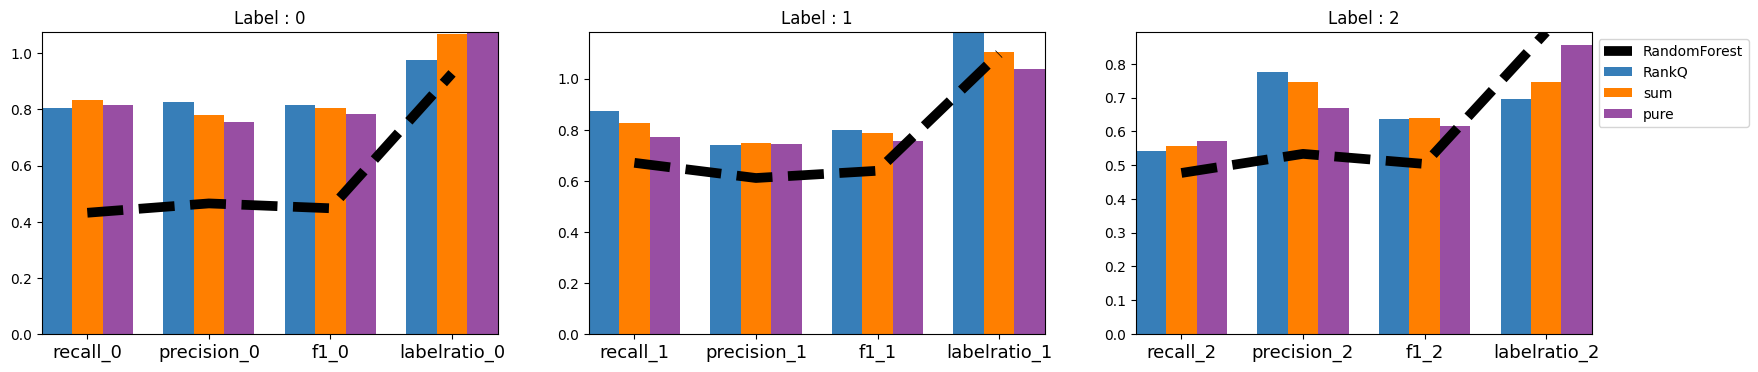

In [44]:
plot_label_detail(label2name, encodercolor, resultdict)

In [87]:
showcolumn = ['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'NumLayer', 'Scorer',
       'ScorerNumLayer', 'f1_micro', 'f1_macro','f1_0', 'labelratio_0','f1_1', 'labelratio_1', 'f1_2', 'labelratio_2']

In [88]:
d[showcolumn].head(20)

,Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer,f1_micro,f1_macro,f1_0,labelratio_0,f1_1,labelratio_1,f1_2,labelratio_2
2,RandomForest,-,-,-,-,0,-,0,0.926283,0.837886,0.960947,1.008109,0.861136,0.986443,0.691574,0.94050
3,MLP,-,-,-,-,0,-,0,0.809898,0.623154,0.888458,1.092769,0.580874,0.793587,0.400130,0.53700
13,transformer,rw,pure,AvgAgg,-,2,sm,1,0.829435,0.603395,0.901502,1.059550,0.704918,0.973551,0.203765,0.35450
12,transformer,rw,RankQ,AvgAgg,-,2,sm,1,0.835088,0.597509,0.904541,1.049762,0.717560,1.040146,0.170426,0.19700
11,hnhn,adj,-,-,-,2,sm,1,0.759482,0.562134,0.859471,1.049684,0.533746,0.943677,0.293184,0.60650
15,gat,rw,-,-,-,2,sm,1,0.791172,0.506941,0.879151,0.989584,0.641671,1.267446,0.000000,0.00000
10,gat,adj,-,-,-,2,sm,1,0.784740,0.502955,0.879661,1.033293,0.599467,1.126107,0.029736,0.04250
14,gat,rw,sum,-,-,2,sm,1,0.792927,0.489943,0.882957,1.120436,0.586872,0.874365,0.000000,0.00000
5,gat,onehot,sum,-,-,2,sm,1,0.737594,0.482050,0.850404,1.219724,0.338782,0.452001,0.256965,0.52550
9,gat,adj,sum,-,-,2,sm,1,0.777360,0.481715,0.875579,1.063244,0.569565,1.046168,0.000000,0.00000


## Groupby

In [72]:
a = d[d["Encode"] != "PosEnc"]
a['name'] = a['Model'] + "-" + a["Encode"] + "-" + a["Partial"]

for exceptname in ["transformer-sum-", "transformer-sum-partial", 'transformer-pure-partial']:
    a = a[a["name"] != exceptname]
a = a.loc[a.groupby(['name'])['f1_macro'].idxmax()]
a

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Model,InitVec,Encode,Decode,Partial,NumLayer,Scorer,ScorerNumLayer,f1_micro,f1_macro,...,recall_1,precision_1,f1_1,labelratio_1,recall_2,precision_2,f1_2,labelratio_2,searchspace,name
4,LogisticRegressor,-,-,-,-,0,-,0,0.534680,0.443809,...,0.825134,0.557500,0.665414,1.480060,0.37475,0.478455,0.420300,0.78325,1,LogisticRegressor----
3,MLP,-,-,-,-,0,-,0,0.552919,0.479868,...,0.813348,0.576998,0.675084,1.409620,0.39375,0.510039,0.444413,0.77200,1,MLP----
2,RandomForest,-,-,-,-,0,-,0,0.557430,0.530253,...,0.670412,0.610965,0.639310,1.097300,0.47675,0.533277,0.503432,0.89400,1,RandomForest----
1,baseline0,-,-,-,-,0,-,0,0.335948,0.329427,...,0.330958,0.478123,0.391156,0.692202,0.33450,0.265108,0.295789,1.26175,1,baseline0----
0,baseline1,-,-,-,-,0,-,0,0.477022,0.215308,...,1.000000,0.477022,0.645924,2.096341,0.00000,0.000000,0.000000,0.00000,1,baseline1----
52,gat,rw,-,-,-,2,sm,1,0.498287,0.438797,...,0.719499,0.549224,0.622935,1.310028,0.25350,0.383510,0.305238,0.66100,3,gat----
37,gat,adj,sum,-,-,2,sm,1,0.500000,0.381979,...,0.863510,0.507033,0.638912,1.703064,0.15500,0.647182,0.250101,0.23950,5,gat-sum--
54,hnhn,rw,-,-,-,2,sm,1,0.521212,0.493391,...,0.630084,0.569343,0.598175,1.106685,0.30500,0.363962,0.331882,0.83800,6,hnhn----
47,transformer,rw,RankQ,AvgAgg,-,2,sm,1,0.768116,0.751285,...,0.873816,0.738813,0.800664,1.182730,0.54050,0.776023,0.637194,0.69650,4,transformer-RankQ--
56,transformer,rw,RankQ,AvgAgg,partial,2,sm,1,0.615415,0.556690,...,0.821727,0.647924,0.724549,1.268245,0.26900,0.523346,0.355350,0.51400,2,transformer-RankQ-partial


In [73]:
a.columns

Index(['Model', 'InitVec', 'Encode', 'Decode', 'Partial', 'NumLayer', 'Scorer',
       'ScorerNumLayer', 'f1_micro', 'f1_macro', 'recall_0', 'precision_0',
       'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1',
       'labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2',
       'searchspace', 'name'],
      dtype='object')

In [74]:
postprocessed_result = {}
for i, row in a.iterrows():
    res = {}
    for colname in ['f1_micro', 'f1_macro', 'recall_0', 'precision_0', 'f1_0', 'labelratio_0', 'recall_1', 'precision_1', 'f1_1','labelratio_1', 'recall_2', 'precision_2', 'f1_2', 'labelratio_2']:
        res[colname] = row[colname]
    postprocessed_result[row["name"]] = res

In [75]:
modelcolor = {
    "baseline0----" : "#000000",
    "baseline1----": "#000000",
    
    # brown
    "RandomForest----": "#9A7745", 
    "MLP----": "#D27328",
    "LogisticRegressor----": "#8B4513",
    
    # dark
    "hnhn----": "#440075",
    "transformer-pure--": "#0000FF",
    "gat----": "#CD1039",
    
    # mid
    #       red
    "gat-sum--": "#FF7A85",
    #       blue
    "transformer-RankQ--": "#0078FF",
    "transformer-RankQ-partial": "#64CD3C", 
    
    # light
#     "limit/gat_concat": "#FFCD28", 
#     "limit/gat_sum": "#FFCD28",
#     #       green -> yellow green
#     "limit/transformer_concat": "#64CD3C", 
#     "limit/transformer_sum": "#64CD3C", 
#     "limit/transformer2": "#64CD3C"
}

In [76]:
modellist = ['transformer-RankQ--', 'transformer-RankQ-partial', 'transformer-pure--', 'gat-sum--', 'gat----', 'hnhn----']
# modellist = ['transformer-RankQ--', 'transformer-pure--', 'gat-sum--', 'gat----', 'hnhn----']
baseline = ['RandomForest----']

In [77]:
def plot_total_eval2(modellist, baseline, colordict, result):
    fig, axes = plt.subplots(dpi=100, figsize=(12,4), nrows=1, ncols=2)
    
    xs = modellist
    
    for eidx, evalname in enumerate(["f1_micro", "f1_macro"]):
        for modelname in modellist + baseline:
            if modelname not in result:
                continue
            axes[eidx].bar(modelname, result[modelname][evalname], align='center', label=modelname, color=colordict[modelname])
            
        axes[eidx].set_xticks([])
#         axes[eidx].set_xticklabels(xs, fontsize=13, rotation=90)
        axes[eidx].set_title(evalname)
        axes[eidx].autoscale(tight=True)
        if eidx == 1:
            axes[eidx].legend(bbox_to_anchor=(1,1))

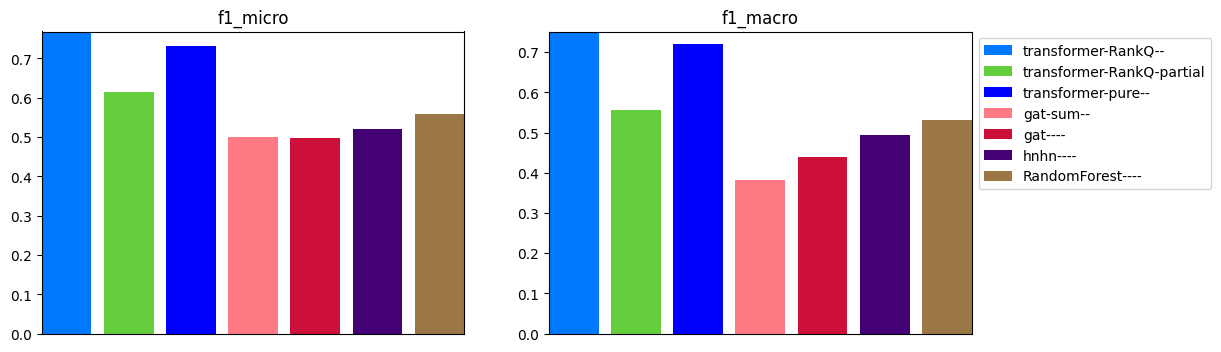

In [78]:
plot_total_eval2(modellist, baseline, modelcolor, postprocessed_result)

In [79]:
def plot_label_detail2(modellist, baseline, colordict, result, w=1/7):
    fig, axes = plt.subplots(dpi=100, figsize=(20,4), nrows=1, ncols=3)

    for l in range(3):
        ax = axes[l]
        evallist = ['recall_' + str(l), 'precision_' + str(l), 'f1_' + str(l), 'labelratio_' + str(l)]
        for midx, modelname in enumerate(modellist):
            if modelname not in result:
                continue
            ys = [result[modelname][e] for e in evallist]
            ax.bar(np.arange(len(evallist)) + (w * (midx-2)), ys, width=w, align='center', label=modelname, color=colordict[modelname])
        for midx, modelname in enumerate(baseline):
            xs = []
            ys = []
            for eidx, e in enumerate(evallist):
                for i in range(len(modellist)):
                    ys.append(result[modelname][e])
                    xs.append(eidx + w * (i - 2))
            ax.plot(xs, ys, label=modelname, color=colordict[modelname], linewidth=4, linestyle="dashed")
        
        ax.set_xticks(np.arange(len(evallist)))
        ax.set_xticklabels(evallist, fontsize=13)

        if l == 2:
            ax.legend(bbox_to_anchor=(1,1))
        # ax.xaxis_date()
        ax.set_title("Label : " + str(l))
        ax.autoscale(tight=True)

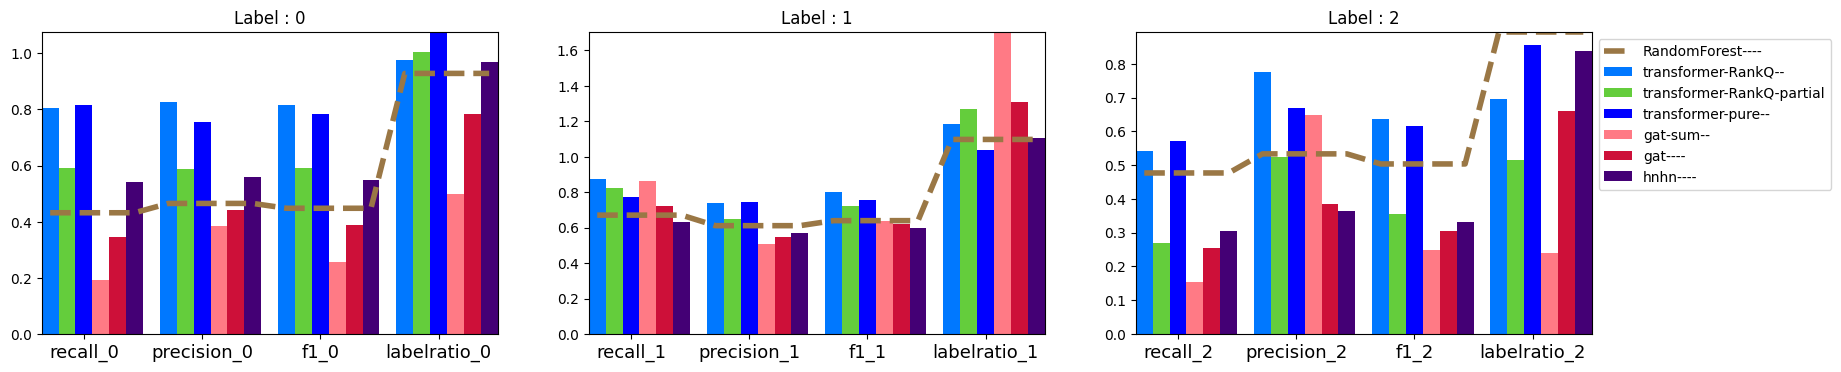

In [80]:
plot_label_detail2(modellist, baseline, modelcolor, postprocessed_result)